In [2]:
!python -V

Python 3.10.14


In [3]:
import pandas as pd

In [4]:
import pickle

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

### 2.2

In [1]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
#mlflow.set_experiment("nyc-taxi-experiment")
mlflow.set_experiment("demo-study-group-w2-part1")

2024/06/08 22:41:28 INFO mlflow.tracking.fluent: Experiment with name 'demo-study-group-w2-part1' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/gabriel/workspace/selfstudy/mlops_zoomcamp/02-experiment-tracking/mlruns/4', creation_time=1717900888078, experiment_id='4', last_update_time=1717900888078, lifecycle_stage='active', name='demo-study-group-w2-part1', tags={}>

In [7]:
df = pd.read_parquet('./data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829445

/var/folders/09/p_32v97x0m92g9kb_3v9t2wm0000gn/T/ipykernel_6886/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/09/p_32v97x0m92g9kb_3v9t2wm0000gn/T/ipykernel_6886/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label

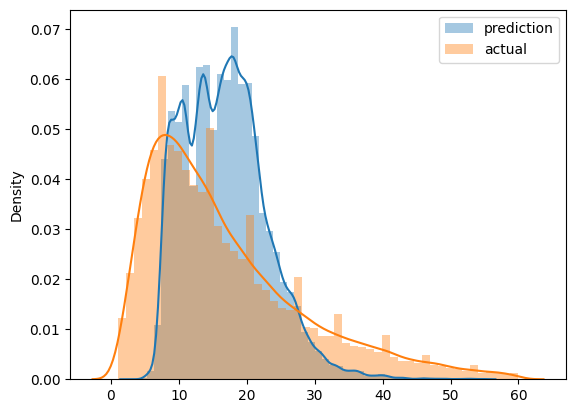

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [12]:
len(df_train), len(df_val)

(73908, 61921)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715208946364

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

### 2.2 and 2.3
after this, go check out MLflow UI (for dataset, creator, compare first 2 runs)

In [19]:
with mlflow.start_run():

  # log who develop this
  mlflow.set_tag("develper", "gabe")
  # log dataset
  mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
  mlflow.log_param("val-data-path", "./data/green_tripdata_2021-02.parquet")
  # log parameters
  alpha = 0.1
  mlflow.log_param("alpha", alpha)

  lr = Lasso(alpha)
  lr.fit(X_train, y_train)

  y_pred = lr.predict(X_val)

  rmse = mean_squared_error(y_val, y_pred, squared=False)
  # log metrics
  mlflow.log_metric("rmse", rmse)
  # 2.4 log artifacts 
  mlflow.log_artifact(local_path='./models/lin_reg.bin' ,artifact_path='models_pickle')

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [22]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

### 2.3
define training/validation set

In [23]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

### 2.3
objective function for xgboost experiment

In [24]:
def objective(params):
  with mlflow.start_run():
    mlflow.set_tag("model", "xgboost")
    mlflow.log_params(params)
    booster = xgb.train(
      params=params,
      dtrain=train,
      num_boost_round=100,
      evals=[(valid, 'validation')],
      early_stopping_rounds=50
    )
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

  return {'loss': rmse, 'status': STATUS_OK}


### 2.3
https://hyperopt.github.io/hyperopt/getting-started/search_spaces/#:~:text=hp.-,quniform,-(label%2C%20low%2C%20high


In [25]:
search_space = {
  'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0), # range from exp(-3) to exp(0)
  'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
  'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
  'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
  'objective': 'reg:linear',
  'seed': 42
}
# fmin: given objective function, minimize the output
# tpe: algorithm for running the optimization
# max_evals: max number of iterations
best_result = fmin(
  fn=objective,
  space=search_space,
  algo=tpe.suggest,
  max_evals=50,
  trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:00:10] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.54445                          
[1]	validation-rmse:9.34555                           
[2]	validation-rmse:8.49839                           
[3]	validation-rmse:7.91198                           
[4]	validation-rmse:7.50405                           
[5]	validation-rmse:7.22705                           
[6]	validation-rmse:7.03628                           
[7]	validation-rmse:6.90625                           
[8]	validation-rmse:6.81746                           
[9]	validation-rmse:6.75278                           
[10]	validation-rmse:6.70046                          
[11]	validation-rmse:6.66507                          
[12]	validation-rmse:6.63869                          
[13]	validation-rmse:6.61947                          
[14]	validation-rmse:6.60437                          
[15]	validation-rmse:6.59466                          
[16]	validation-rmse:6.58662                          
[17]	validation-rmse:6.57870                          
[18]	valid

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:00:20] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.97925                                                    
[2]	validation-rmse:6.80392                                                    
[3]	validation-rmse:6.73835                                                    
[4]	validation-rmse:6.70656                                                    
[5]	validation-rmse:6.69093                                                    
[6]	validation-rmse:6.68687                                                    
[7]	validation-rmse:6.68470                                                    
[8]	validation-rmse:6.67957                                                    
[9]	validation-rmse:6.67680                                                    
[10]	validation-rmse:6.67711                                                   
[11]	validation-rmse:6.67563                                                   
[12]	validation-rmse:6.67517                                                   
[13]	validation-rmse:6.67422            

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:00:29] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:10.70669                                                   
[2]	validation-rmse:10.10197                                                   
[3]	validation-rmse:9.58174                                                    
[4]	validation-rmse:9.13678                                                    
[5]	validation-rmse:8.75670                                                    
[6]	validation-rmse:8.43322                                                    
[7]	validation-rmse:8.15862                                                    
[8]	validation-rmse:7.92538                                                    
[9]	validation-rmse:7.73034                                                    
[10]	validation-rmse:7.56616                                                   
[11]	validation-rmse:7.42596                                                   
[12]	validation-rmse:7.30627                                                   
[13]	validation-rmse:7.20929            

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:00:35] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:11.31127                                                   
[2]	validation-rmse:10.91173                                                   
[3]	validation-rmse:10.54358                                                   
[4]	validation-rmse:10.20498                                                   
[5]	validation-rmse:9.89343                                                    
[6]	validation-rmse:9.60739                                                    
[7]	validation-rmse:9.34537                                                    
[8]	validation-rmse:9.10565                                                    
[9]	validation-rmse:8.88667                                                    
[10]	validation-rmse:8.68637                                                   
[11]	validation-rmse:8.50384                                                   
[12]	validation-rmse:8.33746                                                   
[13]	validation-rmse:8.18622            

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:00:42] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.76665                                                    
[2]	validation-rmse:7.94571                                                    
[3]	validation-rmse:7.45385                                                    
[4]	validation-rmse:7.16334                                                    
[5]	validation-rmse:6.99090                                                    
[6]	validation-rmse:6.88809                                                    
[7]	validation-rmse:6.81948                                                    
[8]	validation-rmse:6.77624                                                    
[9]	validation-rmse:6.74697                                                    
[10]	validation-rmse:6.72916                                                   
[11]	validation-rmse:6.71497                                                   
[12]	validation-rmse:6.70434                                                   
[13]	validation-rmse:6.69407            

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:00:47] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.80545                                                    
[1]	validation-rmse:7.42990                                                    
[2]	validation-rmse:6.91258                                                    
[3]	validation-rmse:6.71623                                                    
[4]	validation-rmse:6.62668                                                    
[5]	validation-rmse:6.58557                                                    
[6]	validation-rmse:6.56080                                                    
[7]	validation-rmse:6.54801                                                    
[8]	validation-rmse:6.53736                                                    
[9]	validation-rmse:6.53395                                                    
[10]	validation-rmse:6.52822                                                   
[11]	validation-rmse:6.52473                                                   
[12]	validation-rmse:6.52034            

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:00:51] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.01988                                                   
[1]	validation-rmse:10.05811                                                   
[2]	validation-rmse:9.28879                                                    
[3]	validation-rmse:8.68079                                                    
[4]	validation-rmse:8.20151                                                    
[5]	validation-rmse:7.82870                                                    
[6]	validation-rmse:7.53958                                                    
[7]	validation-rmse:7.31399                                                    
[8]	validation-rmse:7.14215                                                    
[9]	validation-rmse:7.00697                                                    
[10]	validation-rmse:6.90226                                                   
[11]	validation-rmse:6.82082                                                   
[12]	validation-rmse:6.75755            

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:01:00] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.91926                                                    
[1]	validation-rmse:6.56148                                                    
[2]	validation-rmse:6.51725                                                    
[3]	validation-rmse:6.50071                                                    
[4]	validation-rmse:6.48100                                                    
[5]	validation-rmse:6.47330                                                    
[6]	validation-rmse:6.46437                                                    
[7]	validation-rmse:6.45042                                                    
[8]	validation-rmse:6.44013                                                    
[9]	validation-rmse:6.43403                                                    
[10]	validation-rmse:6.43127                                                   
[11]	validation-rmse:6.42819                                                   
[12]	validation-rmse:6.42401            

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:01:10] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:11.21316                                                   
[2]	validation-rmse:10.77573                                                   
[3]	validation-rmse:10.37629                                                   
[4]	validation-rmse:10.01201                                                   
[5]	validation-rmse:9.68013                                                    
[6]	validation-rmse:9.37844                                                    
[7]	validation-rmse:9.10492                                                    
[8]	validation-rmse:8.85695                                                    
[9]	validation-rmse:8.63258                                                    
[10]	validation-rmse:8.43030                                                   
[11]	validation-rmse:8.24715                                                   
[12]	validation-rmse:8.08238                                                   
[13]	validation-rmse:7.93351            

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:01:18] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:11.43655                                                   
[2]	validation-rmse:11.08615                                                   
[3]	validation-rmse:10.75933                                                   
[4]	validation-rmse:10.45487                                                   
[5]	validation-rmse:10.17137                                                   
[6]	validation-rmse:9.90770                                                    
[7]	validation-rmse:9.66271                                                    
[8]	validation-rmse:9.43519                                                    
[9]	validation-rmse:9.22420                                                    
[10]	validation-rmse:9.02877                                                   
[11]	validation-rmse:8.84793                                                   
[12]	validation-rmse:8.68064                                                   
[13]	validation-rmse:8.52604            

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:01:24] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.46430                                                     
[3]	validation-rmse:7.11133                                                     
[4]	validation-rmse:6.93581                                                     
[5]	validation-rmse:6.84493                                                     
[6]	validation-rmse:6.79233                                                     
[7]	validation-rmse:6.75816                                                     
[8]	validation-rmse:6.73553                                                     
[9]	validation-rmse:6.71462                                                     
[10]	validation-rmse:6.70075                                                    
[11]	validation-rmse:6.69212                                                    
[12]	validation-rmse:6.68669                                                    
[13]	validation-rmse:6.68493                                                    
[14]	validation-rmse:6.68259

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:01:33] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.73509                                                    
[1]	validation-rmse:9.61265                                                     
[2]	validation-rmse:8.77182                                                     
[3]	validation-rmse:8.15027                                                     
[4]	validation-rmse:7.69686                                                     
[5]	validation-rmse:7.36998                                                     
[6]	validation-rmse:7.13289                                                     
[7]	validation-rmse:6.96213                                                     
[8]	validation-rmse:6.84063                                                     
[9]	validation-rmse:6.74915                                                     
[10]	validation-rmse:6.68198                                                    
[11]	validation-rmse:6.63172                                                    
[12]	validation-rmse:6.59282

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:01:43] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.43709                                                    
[1]	validation-rmse:9.18317                                                     
[2]	validation-rmse:8.31225                                                     
[3]	validation-rmse:7.72371                                                     
[4]	validation-rmse:7.32942                                                     
[5]	validation-rmse:7.06669                                                     
[6]	validation-rmse:6.89028                                                     
[7]	validation-rmse:6.77374                                                     
[8]	validation-rmse:6.69093                                                     
[9]	validation-rmse:6.63312                                                     
[10]	validation-rmse:6.59319                                                    
[11]	validation-rmse:6.56431                                                    
[12]	validation-rmse:6.54227

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:01:50] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:10.69240                                                    
[2]	validation-rmse:10.08398                                                    
[3]	validation-rmse:9.56118                                                     
[4]	validation-rmse:9.11419                                                     
[5]	validation-rmse:8.73435                                                     
[6]	validation-rmse:8.41213                                                     
[7]	validation-rmse:8.13997                                                     
[8]	validation-rmse:7.91046                                                     
[9]	validation-rmse:7.71702                                                     
[10]	validation-rmse:7.55474                                                    
[11]	validation-rmse:7.41882                                                    
[12]	validation-rmse:7.30443                                                    
[13]	validation-rmse:7.20887

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:01:53] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.71940                                                     
[2]	validation-rmse:6.68818                                                     
[3]	validation-rmse:6.67786                                                     
[4]	validation-rmse:6.67326                                                     
[5]	validation-rmse:6.66588                                                     
[6]	validation-rmse:6.65992                                                     
[7]	validation-rmse:6.65572                                                     
[8]	validation-rmse:6.65427                                                     
[9]	validation-rmse:6.65260                                                     
[10]	validation-rmse:6.65163                                                    
[11]	validation-rmse:6.64762                                                    
[12]	validation-rmse:6.64814                                                    
[13]	validation-rmse:6.64651

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:01:58] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.42916                                                     
[1]	validation-rmse:7.96076                                                     
[2]	validation-rmse:7.22343                                                     
[3]	validation-rmse:6.87021                                                     
[4]	validation-rmse:6.69242                                                     
[5]	validation-rmse:6.59488                                                     
[6]	validation-rmse:6.54320                                                     
[7]	validation-rmse:6.50697                                                     
[8]	validation-rmse:6.48701                                                     
[9]	validation-rmse:6.47430                                                     
[10]	validation-rmse:6.46277                                                    
[11]	validation-rmse:6.44920                                                    
[12]	validation-rmse:6.44418

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:02:07] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.78226                                                     
[1]	validation-rmse:6.68238                                                     
[2]	validation-rmse:6.66948                                                     
[3]	validation-rmse:6.65996                                                     
[4]	validation-rmse:6.65005                                                     
[5]	validation-rmse:6.64902                                                     
[6]	validation-rmse:6.64696                                                     
[7]	validation-rmse:6.64081                                                     
[8]	validation-rmse:6.64690                                                     
[9]	validation-rmse:6.64263                                                     
[10]	validation-rmse:6.64291                                                    
[11]	validation-rmse:6.64242                                                    
[12]	validation-rmse:6.64322

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:02:16] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.01892                                                     
[1]	validation-rmse:6.99261                                                     
[2]	validation-rmse:6.73755                                                     
[3]	validation-rmse:6.65962                                                     
[4]	validation-rmse:6.62604                                                     
[5]	validation-rmse:6.61272                                                     
[6]	validation-rmse:6.60467                                                     
[7]	validation-rmse:6.59645                                                     
[8]	validation-rmse:6.59506                                                     
[9]	validation-rmse:6.59203                                                     
[10]	validation-rmse:6.58655                                                    
[11]	validation-rmse:6.57816                                                    
[12]	validation-rmse:6.57420

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:02:24] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.33714                                                    
[1]	validation-rmse:10.58798                                                    
[2]	validation-rmse:9.94841                                                     
[3]	validation-rmse:9.40063                                                     
[4]	validation-rmse:8.94381                                                     
[5]	validation-rmse:8.55805                                                     
[6]	validation-rmse:8.23328                                                     
[7]	validation-rmse:7.96492                                                     
[8]	validation-rmse:7.73301                                                     
[9]	validation-rmse:7.54928                                                     
[10]	validation-rmse:7.39134                                                    
[11]	validation-rmse:7.26031                                                    
[12]	validation-rmse:7.15406

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:02:38] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.18729                                                     
[1]	validation-rmse:6.66556                                                     
[2]	validation-rmse:6.56685                                                     
[3]	validation-rmse:6.54417                                                     
[4]	validation-rmse:6.52897                                                     
[5]	validation-rmse:6.51845                                                     
[6]	validation-rmse:6.51224                                                     
[7]	validation-rmse:6.50771                                                     
[8]	validation-rmse:6.49491                                                     
[9]	validation-rmse:6.49102                                                     
[10]	validation-rmse:6.48727                                                    
[11]	validation-rmse:6.48325                                                    
[12]	validation-rmse:6.48003

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:02:45] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.85128                                                    
[1]	validation-rmse:9.78831                                                     
[2]	validation-rmse:8.96871                                                     
[3]	validation-rmse:8.34429                                                     
[4]	validation-rmse:7.86721                                                     
[5]	validation-rmse:7.51278                                                     
[6]	validation-rmse:7.24918                                                     
[7]	validation-rmse:7.05299                                                     
[8]	validation-rmse:6.90813                                                     
[9]	validation-rmse:6.79864                                                     
[10]	validation-rmse:6.71549                                                    
[11]	validation-rmse:6.65299                                                    
[12]	validation-rmse:6.60720

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:03:00] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.74731                                                     
[1]	validation-rmse:8.29417                                                     
[2]	validation-rmse:7.47315                                                     
[3]	validation-rmse:7.02979                                                     
[4]	validation-rmse:6.78088                                                     
[5]	validation-rmse:6.64899                                                     
[6]	validation-rmse:6.57000                                                     
[7]	validation-rmse:6.52159                                                     
[8]	validation-rmse:6.48747                                                     
[9]	validation-rmse:6.46457                                                     
[10]	validation-rmse:6.44823                                                    
[11]	validation-rmse:6.43765                                                    
[12]	validation-rmse:6.42782

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:03:11] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[7]	validation-rmse:7.57949                                                     
[8]	validation-rmse:7.40581                                                     
[9]	validation-rmse:7.27043                                                     
[10]	validation-rmse:7.16342                                                    
[11]	validation-rmse:7.08056                                                    
[12]	validation-rmse:7.01408                                                    
[13]	validation-rmse:6.96342                                                    
[14]	validation-rmse:6.92322                                                    
[15]	validation-rmse:6.89252                                                    
[16]	validation-rmse:6.86653                                                    
[17]	validation-rmse:6.84517                                                    
[18]	validation-rmse:6.82844                                                    
[19]	validation-rmse:6.81380

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:03:13] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.88190                                                     
[1]	validation-rmse:8.45192                                                     
[2]	validation-rmse:7.60867                                                     
[3]	validation-rmse:7.12929                                                     
[4]	validation-rmse:6.85386                                                     
[5]	validation-rmse:6.69616                                                     
[6]	validation-rmse:6.60104                                                     
[7]	validation-rmse:6.54462                                                     
[8]	validation-rmse:6.50768                                                     
[9]	validation-rmse:6.48027                                                     
[10]	validation-rmse:6.46171                                                    
[11]	validation-rmse:6.44849                                                    
[12]	validation-rmse:6.43800

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:03:25] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.88052                                                     
[1]	validation-rmse:8.48193                                                     
[2]	validation-rmse:7.67439                                                     
[3]	validation-rmse:7.21303                                                     
[4]	validation-rmse:6.94646                                                     
[5]	validation-rmse:6.80734                                                     
[6]	validation-rmse:6.71367                                                     
[7]	validation-rmse:6.66152                                                     
[8]	validation-rmse:6.62673                                                     
[9]	validation-rmse:6.59971                                                     
[10]	validation-rmse:6.58284                                                    
[11]	validation-rmse:6.57308                                                    
[12]	validation-rmse:6.56547

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:03:35] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.70469                                                     
[1]	validation-rmse:7.31041                                                     
[2]	validation-rmse:6.80155                                                     
[3]	validation-rmse:6.60376                                                     
[4]	validation-rmse:6.52864                                                     
[5]	validation-rmse:6.48754                                                     
[6]	validation-rmse:6.46399                                                     
[7]	validation-rmse:6.44710                                                     
[8]	validation-rmse:6.43952                                                     
[9]	validation-rmse:6.43361                                                     
[10]	validation-rmse:6.42966                                                    
[11]	validation-rmse:6.42386                                                    
[12]	validation-rmse:6.41879

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:03:45] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.70362                                                     
[1]	validation-rmse:7.32608                                                     
[2]	validation-rmse:6.82183                                                     
[3]	validation-rmse:6.63197                                                     
[4]	validation-rmse:6.54146                                                     
[5]	validation-rmse:6.49723                                                     
[6]	validation-rmse:6.47636                                                     
[7]	validation-rmse:6.46024                                                     
[8]	validation-rmse:6.44875                                                     
[9]	validation-rmse:6.44182                                                     
[10]	validation-rmse:6.43741                                                    
[11]	validation-rmse:6.43304                                                    
[12]	validation-rmse:6.42885

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:03:54] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.47686                                                    
[1]	validation-rmse:9.24922                                                     
[2]	validation-rmse:8.39975                                                     
[3]	validation-rmse:7.80857                                                     
[4]	validation-rmse:7.41879                                                     
[5]	validation-rmse:7.15325                                                     
[6]	validation-rmse:6.97375                                                     
[7]	validation-rmse:6.84083                                                     
[8]	validation-rmse:6.75878                                                     
[9]	validation-rmse:6.69742                                                     
[10]	validation-rmse:6.65242                                                    
[11]	validation-rmse:6.62108                                                    
[12]	validation-rmse:6.59328

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:04:12] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.21466                                                    
[1]	validation-rmse:8.90258                                                     
[2]	validation-rmse:8.03891                                                     
[3]	validation-rmse:7.51217                                                     
[4]	validation-rmse:7.16619                                                     
[5]	validation-rmse:6.95192                                                     
[6]	validation-rmse:6.81818                                                     
[7]	validation-rmse:6.73496                                                     
[8]	validation-rmse:6.67220                                                     
[9]	validation-rmse:6.63309                                                     
[10]	validation-rmse:6.60413                                                    
[11]	validation-rmse:6.58060                                                    
[12]	validation-rmse:6.56671

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:04:26] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.35277                                                     
[1]	validation-rmse:7.87827                                                     
[2]	validation-rmse:7.16764                                                     
[3]	validation-rmse:6.83000                                                     
[4]	validation-rmse:6.66436                                                     
[5]	validation-rmse:6.57718                                                     
[6]	validation-rmse:6.52576                                                     
[7]	validation-rmse:6.49509                                                     
[8]	validation-rmse:6.47736                                                     
[9]	validation-rmse:6.46473                                                     
[10]	validation-rmse:6.45635                                                    
[11]	validation-rmse:6.45221                                                    
[12]	validation-rmse:6.44786

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:04:33] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.15829                                                     
[2]	validation-rmse:6.79652                                                     
[3]	validation-rmse:6.67119                                                     
[4]	validation-rmse:6.61448                                                     
[5]	validation-rmse:6.59147                                                     
[6]	validation-rmse:6.57534                                                     
[7]	validation-rmse:6.55899                                                     
[8]	validation-rmse:6.55203                                                     
[9]	validation-rmse:6.54815                                                     
[10]	validation-rmse:6.54449                                                    
[11]	validation-rmse:6.53651                                                    
[12]	validation-rmse:6.53291                                                    
[13]	validation-rmse:6.53024

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:04:39] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.25373                                                     
[1]	validation-rmse:7.82813                                                     
[2]	validation-rmse:7.16968                                                     
[3]	validation-rmse:6.86480                                                     
[4]	validation-rmse:6.71452                                                     
[5]	validation-rmse:6.63914                                                     
[6]	validation-rmse:6.59378                                                     
[7]	validation-rmse:6.56954                                                     
[8]	validation-rmse:6.55305                                                     
[9]	validation-rmse:6.54580                                                     
[10]	validation-rmse:6.53789                                                    
[11]	validation-rmse:6.53304                                                    
[12]	validation-rmse:6.52841

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:04:48] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.96305                                                     
[1]	validation-rmse:6.87530                                                     
[2]	validation-rmse:6.59881                                                     
[3]	validation-rmse:6.51263                                                     
[4]	validation-rmse:6.47970                                                     
[5]	validation-rmse:6.46353                                                     
[6]	validation-rmse:6.45031                                                     
[7]	validation-rmse:6.44002                                                     
[8]	validation-rmse:6.43182                                                     
[9]	validation-rmse:6.42452                                                     
[10]	validation-rmse:6.42007                                                    
[11]	validation-rmse:6.41542                                                    
[12]	validation-rmse:6.41063

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:04:56] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.35265                                                     
[1]	validation-rmse:6.68654                                                     
[2]	validation-rmse:6.57095                                                     
[3]	validation-rmse:6.53714                                                     
[4]	validation-rmse:6.53261                                                     
[5]	validation-rmse:6.52587                                                     
[6]	validation-rmse:6.51300                                                     
[7]	validation-rmse:6.50153                                                     
[8]	validation-rmse:6.49494                                                     
[9]	validation-rmse:6.48841                                                     
[10]	validation-rmse:6.48333                                                    
[11]	validation-rmse:6.47491                                                    
[12]	validation-rmse:6.47076

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:05:01] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:9.07794                                                     
[4]	validation-rmse:8.61456                                                     
[5]	validation-rmse:8.23902                                                     
[6]	validation-rmse:7.93955                                                     
[7]	validation-rmse:7.69843                                                     
[8]	validation-rmse:7.50611                                                     
[9]	validation-rmse:7.35202                                                     
[10]	validation-rmse:7.22912                                                    
[11]	validation-rmse:7.13157                                                    
[12]	validation-rmse:7.05304                                                    
[13]	validation-rmse:6.98983                                                    
[14]	validation-rmse:6.93839                                                    
[15]	validation-rmse:6.89690

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:05:04] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.62426                                                    
[1]	validation-rmse:11.09033                                                    
[2]	validation-rmse:10.60752                                                    
[3]	validation-rmse:10.17101                                                    
[4]	validation-rmse:9.77843                                                     
[5]	validation-rmse:9.42380                                                     
[6]	validation-rmse:9.10543                                                     
[7]	validation-rmse:8.81974                                                     
[8]	validation-rmse:8.56344                                                     
[9]	validation-rmse:8.33733                                                     
[10]	validation-rmse:8.13414                                                    
[11]	validation-rmse:7.95260                                                    
[12]	validation-rmse:7.79286

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:05:21] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.10635                                                     
[1]	validation-rmse:7.66750                                                     
[2]	validation-rmse:7.04497                                                     
[3]	validation-rmse:6.77927                                                     
[4]	validation-rmse:6.65865                                                     
[5]	validation-rmse:6.60085                                                     
[6]	validation-rmse:6.56511                                                     
[7]	validation-rmse:6.54636                                                     
[8]	validation-rmse:6.53534                                                     
[9]	validation-rmse:6.52165                                                     
[10]	validation-rmse:6.51401                                                    
[11]	validation-rmse:6.50966                                                    
[12]	validation-rmse:6.50502

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:05:26] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:9.00569                                                     
[2]	validation-rmse:8.15552                                                     
[3]	validation-rmse:7.61035                                                     
[4]	validation-rmse:7.26240                                                     
[5]	validation-rmse:7.04091                                                     
[6]	validation-rmse:6.89557                                                     
[7]	validation-rmse:6.80110                                                     
[8]	validation-rmse:6.73597                                                     
[9]	validation-rmse:6.69189                                                     
[10]	validation-rmse:6.66083                                                    
[11]	validation-rmse:6.63987                                                    
[12]	validation-rmse:6.62305                                                    
[13]	validation-rmse:6.61094

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:05:32] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.72435                                                    
[1]	validation-rmse:9.60829                                                     
[2]	validation-rmse:8.77233                                                     
[3]	validation-rmse:8.16972                                                     
[4]	validation-rmse:7.72195                                                     
[5]	validation-rmse:7.41212                                                     
[6]	validation-rmse:7.18418                                                     
[7]	validation-rmse:7.01217                                                     
[8]	validation-rmse:6.89186                                                     
[9]	validation-rmse:6.80114                                                     
[10]	validation-rmse:6.74392                                                    
[11]	validation-rmse:6.69278                                                    
[12]	validation-rmse:6.65848

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:05:52] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.54334                                                    
[1]	validation-rmse:10.94370                                                    
[2]	validation-rmse:10.40789                                                    
[3]	validation-rmse:9.93073                                                     
[4]	validation-rmse:9.50643                                                     
[5]	validation-rmse:9.13122                                                     
[6]	validation-rmse:8.80099                                                     
[7]	validation-rmse:8.50930                                                     
[8]	validation-rmse:8.25164                                                     
[9]	validation-rmse:8.02497                                                     
[10]	validation-rmse:7.82644                                                    
[11]	validation-rmse:7.65334                                                    
[12]	validation-rmse:7.50332

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:06:20] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.94206                                                     
[1]	validation-rmse:8.54272                                                     
[2]	validation-rmse:7.71057                                                     
[3]	validation-rmse:7.22296                                                     
[4]	validation-rmse:6.94431                                                     
[5]	validation-rmse:6.77979                                                     
[6]	validation-rmse:6.68258                                                     
[7]	validation-rmse:6.62186                                                     
[8]	validation-rmse:6.58238                                                     
[9]	validation-rmse:6.55527                                                     
[10]	validation-rmse:6.53510                                                    
[11]	validation-rmse:6.52185                                                    
[12]	validation-rmse:6.51271

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:06:26] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.24553                                                     
[2]	validation-rmse:6.86096                                                     
[3]	validation-rmse:6.72782                                                     
[4]	validation-rmse:6.67971                                                     
[5]	validation-rmse:6.65202                                                     
[6]	validation-rmse:6.64135                                                     
[7]	validation-rmse:6.63508                                                     
[8]	validation-rmse:6.62945                                                     
[9]	validation-rmse:6.62872                                                     
[10]	validation-rmse:6.62393                                                    
[11]	validation-rmse:6.62150                                                    
[12]	validation-rmse:6.61725                                                    
[13]	validation-rmse:6.61290

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:06:30] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.66999                                                     
[1]	validation-rmse:8.23383                                                     
[2]	validation-rmse:7.46050                                                     
[3]	validation-rmse:7.05171                                                     
[4]	validation-rmse:6.83572                                                     
[5]	validation-rmse:6.71892                                                     
[6]	validation-rmse:6.65007                                                     
[7]	validation-rmse:6.60905                                                     
[8]	validation-rmse:6.58164                                                     
[9]	validation-rmse:6.56036                                                     
[10]	validation-rmse:6.54900                                                    
[11]	validation-rmse:6.54021                                                    
[12]	validation-rmse:6.53412

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:06:34] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.09846                                                     
[1]	validation-rmse:7.69322                                                     
[2]	validation-rmse:7.09838                                                     
[3]	validation-rmse:6.82760                                                     
[4]	validation-rmse:6.69748                                                     
[5]	validation-rmse:6.63583                                                     
[6]	validation-rmse:6.60146                                                     
[7]	validation-rmse:6.58104                                                     
[8]	validation-rmse:6.57022                                                     
[9]	validation-rmse:6.56035                                                     
[10]	validation-rmse:6.55306                                                    
[11]	validation-rmse:6.54929                                                    
[12]	validation-rmse:6.54414

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:06:44] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.49784                                                     
[1]	validation-rmse:6.81380                                                     
[2]	validation-rmse:6.69409                                                     
[3]	validation-rmse:6.65586                                                     
[4]	validation-rmse:6.63686                                                     
[5]	validation-rmse:6.63076                                                     
[6]	validation-rmse:6.62367                                                     
[7]	validation-rmse:6.62012                                                     
[8]	validation-rmse:6.61782                                                     
[9]	validation-rmse:6.61596                                                     
[10]	validation-rmse:6.60710                                                    
[11]	validation-rmse:6.60190                                                    
[12]	validation-rmse:6.60038

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:06:53] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.65198                                                    
[1]	validation-rmse:9.48948                                                     
[2]	validation-rmse:8.63914                                                     
[3]	validation-rmse:8.02624                                                     
[4]	validation-rmse:7.59101                                                     
[5]	validation-rmse:7.28313                                                     
[6]	validation-rmse:7.06704                                                     
[7]	validation-rmse:6.91423                                                     
[8]	validation-rmse:6.80530                                                     
[9]	validation-rmse:6.72621                                                     
[10]	validation-rmse:6.66882                                                    
[11]	validation-rmse:6.62575                                                    
[12]	validation-rmse:6.59322

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:07:01] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.22213                                                    
[1]	validation-rmse:10.38871                                                    
[2]	validation-rmse:9.69333                                                     
[3]	validation-rmse:9.11405                                                     
[4]	validation-rmse:8.63274                                                     
[5]	validation-rmse:8.24025                                                     
[6]	validation-rmse:7.91843                                                     
[7]	validation-rmse:7.65617                                                     
[8]	validation-rmse:7.44240                                                     
[9]	validation-rmse:7.26920                                                     
[10]	validation-rmse:7.12767                                                    
[11]	validation-rmse:7.01396                                                    
[12]	validation-rmse:6.92111

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:07:13] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.88606                                                    
[1]	validation-rmse:9.84157                                                     
[2]	validation-rmse:9.03038                                                     
[3]	validation-rmse:8.40463                                                     
[4]	validation-rmse:7.93171                                                     
[5]	validation-rmse:7.57230                                                     
[6]	validation-rmse:7.30180                                                     
[7]	validation-rmse:7.10093                                                     
[8]	validation-rmse:6.94919                                                     
[9]	validation-rmse:6.83686                                                     
[10]	validation-rmse:6.74772                                                    
[11]	validation-rmse:6.68185                                                    
[12]	validation-rmse:6.63154

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:07:27] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.28122                                                    
[1]	validation-rmse:8.96651                                                     
[2]	validation-rmse:8.09330                                                     
[3]	validation-rmse:7.52897                                                     
[4]	validation-rmse:7.16598                                                     
[5]	validation-rmse:6.93692                                                     
[6]	validation-rmse:6.78377                                                     
[7]	validation-rmse:6.68498                                                     
[8]	validation-rmse:6.62001                                                     
[9]	validation-rmse:6.57461                                                     
[10]	validation-rmse:6.54116                                                    
[11]	validation-rmse:6.51915                                                    
[12]	validation-rmse:6.50215

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:07:35] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.61145                                                     
[1]	validation-rmse:8.16064                                                     
[2]	validation-rmse:7.38710                                                     
[3]	validation-rmse:6.98470                                                     
[4]	validation-rmse:6.77585                                                     
[5]	validation-rmse:6.66311                                                     
[6]	validation-rmse:6.59993                                                     
[7]	validation-rmse:6.55723                                                     
[8]	validation-rmse:6.52708                                                     
[9]	validation-rmse:6.50828                                                     
[10]	validation-rmse:6.49608                                                    
[11]	validation-rmse:6.48624                                                    
[12]	validation-rmse:6.47772

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



### 2.3
- find the best model, copy the parameters and reproduce the result
- add autolog (pytorch, tensoflow, keras, xgboost), from 7 parameters to 12 parameters, also found artifacts logged

### 2.4
- log artifacts and model

In [26]:
mlflow.xgboost.autolog()

In [28]:
with mlflow.start_run():
  best_params = {
      "learning_rate": 0.30070237573310177,
      "max_depth": 62,
      "min_child_weight": 1.7064946336172562,
      "objective": "reg:linear",
      "reg_alpha": 0.012171939658517199,
      "reg_lambda": 0.3301990638226685,
      "seed": 42
  }

  mlflow.set_tag("models", "xgboost")
  mlflow.log_params(best_params)

  booster = xgb.train(
    params=best_params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
  )

  y_pred = booster.predict(valid)
  rmse = mean_squared_error(y_val, y_pred, squared=False)
  mlflow.log_metric("rmse", rmse)

  with open("models/preprocessor.b", "wb") as f_out:
    pickle.dump(dv, f_out)
  # 2.4 log artifacts
  mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
  # 2.4 log model
  mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")


/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:35:14] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:9.85864
[1]	validation-rmse:8.42832
[2]	validation-rmse:7.59763
[3]	validation-rmse:7.12340
[4]	validation-rmse:6.85844
[5]	validation-rmse:6.70613
[6]	validation-rmse:6.61323
[7]	validation-rmse:6.55350
[8]	validation-rmse:6.51697
[9]	validation-rmse:6.49273
[10]	validation-rmse:6.47238
[11]	validation-rmse:6.45735
[12]	validation-rmse:6.44728
[13]	validation-rmse:6.44035
[14]	validation-rmse:6.43534
[15]	validation-rmse:6.43200
[16]	validation-rmse:6.42939
[17]	validation-rmse:6.42662
[18]	validation-rmse:6.42325
[19]	validation-rmse:6.41865
[20]	validation-rmse:6.41681
[21]	validation-rmse:6.41512
[22]	validation-rmse:6.41298
[23]	validation-rmse:6.40988
[24]	validation-rmse:6.40725
[25]	validation-rmse:6.40433
[26]	validation-rmse:6.40236
[27]	validation-rmse:6.40040
[28]	validation-rmse:6.39876
[29]	validation-rmse:6.39764
[30]	validation-rmse:6.39592
[31]	validation-rmse:6.39374
[32]	validation-rmse:6.39250
[33]	validation-rmse:6.39049
[34]	validation-rmse:6.3

2024/06/08 23:35:49 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/06/08 23:35:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:35:49] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
2024/06/08 23:35:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesir

### 2.4
load logged model from "artifact" and make prediction with it

In [29]:
logged_model = 'runs:/a35a4f261d94464cae871a57e189b418/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:19:54] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [47]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: a35a4f261d94464cae871a57e189b418

In [49]:
xgboost_model = mlflow.xgboost.load_model(logged_model)
xgboost_model

/Users/gabriel/miniconda3/envs/mlops-w2/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [12:53:26] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [50]:
y_pred = xgboost_model.predict(valid)

In [51]:
y_pred[:10]

array([14.089896 ,  6.7078524, 12.912857 , 24.451832 ,  9.550604 ,
       17.160286 , 10.223085 ,  7.657311 ,  9.613935 , 17.068686 ],
      dtype=float32)